### Mariam Adeyemo
BDP Final Project

## Part 3

**Location of Twitterers**

In [1]:
#Ensure we are using the right kernel
spark.version

'3.1.3'

In [2]:
import os
import subprocess
import shutil
import pandas as pd
from pyspark.sql.functions import *
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.types import *

In [3]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
warnings.filterwarnings(action='ignore')
spark = SparkSession.builder.getOrCreate()

In [5]:
#Add "eagerEval.enabled" to beautify the way Spark DF is displayed
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

In [6]:
# Saving results into individual bucket
bucket_write = 'msca-bdp-data-shared'

### Loading the processed tweet into spark dataframe

In [7]:
path_read = 'gs://msca-bdp-students-bucket/shared_data/mariamoluwatobi/categorised_twitterers'

In [8]:
%%time

tweets_filt2 = spark.read.parquet(path_read)

CPU times: user 9.91 ms, sys: 0 ns, total: 9.91 ms
Wall time: 7.6 s


23/03/09 05:59:31 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [9]:
tweets_filt2.count()

36600074

## Question 2: Where are these Twitterers (all of them, not just influencers) located?

In [10]:
tweets_df = tweets_filt2.select(
            col('user_id'),
            col('user_screen_name'),
            col('user_location'),
            col('user_category'),
            col('tweet_text'),
            col('tweet_created_at')
)

tweets_df.limit(5)

user_id,user_screen_name,user_location,user_category,tweet_text,tweet_created_at
1519012655788220416,bridalblueeyes,null,Someone Else,It was truly an h...,2022-08-02 13:50:40
855619901716930560,Iviebihh,"Downtown, Atlanta",Someone Else,"The ""married by 2...",2022-08-02 13:50:41
1132202998447378432,SA_Kolawole,Nigeria,Someone Else,The University of...,2022-08-02 13:50:41
986685574789713922,TravisBranham_,"Lexington, KY",Social Media Infl...,"Kwame 'KJ' Evans,...",2022-08-02 13:50:42
1351845066592169986,YAMII_SAMAA,"Lagos, Nigeria",Someone Else,WTF is a 25 year ...,2022-08-02 13:50:43


In [11]:
# Extract the year, month, day, and hour from the tweet_created_at column
tweets_df = tweets_df.withColumn("year", year(tweets_df["tweet_created_at"]))
tweets_df = tweets_df.withColumn("month", month(tweets_df["tweet_created_at"]))
tweets_df = tweets_df.withColumn("day", dayofmonth(tweets_df["tweet_created_at"]))
tweets_df = tweets_df.withColumn("hour", hour(tweets_df["tweet_created_at"]))

In [12]:
tweets_df = tweets_df.na.drop(subset=["user_location"])
tweets_df.count()

22405191

In [13]:
#save the sampled tweet into my bucket in a parquet format for easier loading
tweets_df.write.format("parquet").\
mode('overwrite').\
save('gs://msca-bdp-students-bucket/shared_data/mariamoluwatobi/twitterers_loc')

In [7]:
path_read = 'gs://msca-bdp-students-bucket/shared_data/mariamoluwatobi/twitterers_loc'

In [8]:
%%time

tweets_df = spark.read.parquet(path_read)

CPU times: user 7.48 ms, sys: 858 µs, total: 8.34 ms
Wall time: 6.23 s


In [9]:
tweets_df.count()

22405191

In [10]:
# lowercase values in the location column
tweets_df = tweets_df.withColumn("user_location", lower(col("user_location")))
tweets_df.limit(5)

user_id,user_screen_name,user_location,user_category,tweet_text,tweet_created_at,year,month,day,hour
1033370885372211202,Austin2Jacobsen,"kearney, ne",Someone Else,Lopers win set th...,2022-08-31 01:11:16,2022,8,31,1
70307637,thecodyrose,"üt: 30.613384,-96...",Someone Else,True story: Forme...,2022-08-31 01:11:18,2022,8,31,1
628922495,zoemcmahon,"san diego, ca",Someone Else,College is so fun...,2022-08-31 01:11:19,2022,8,31,1
18139940,thelaurenbell,jersey city,News Outlet,How about signing...,2022-08-31 01:11:20,2022,8,31,1
1072209339593752576,NISPEredhawks,ligma and iladies,Someone Else,As a string of Ca...,2022-08-31 01:11:20,2022,8,31,1


### Standardize the location column 

In [15]:
us = ['al', 'ak', 'az', 'ar', 'ca', 'co', 'ct', 'de', 'fl', 'ga', 'hi', 'id', 'il', 'in', 'ia', 'ks', 'ky', 'la', 'me', 'md', 
        'ma', 'mi', 'mn', 'ms', 'mo', 'mt', 'ne', 'nv', 'nh', 'nj', 'nm', 'ny', 'nc', 'nd', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 
        'sd', 'tn', 'tx', 'ut', 'vt', 'va', 'wa', 'wv', 'wi', 'wy', "alabama", "alaska", "arizona", "arkansas", "california", 
        "colorado", "connecticut", "delaware", "florida", "georgia", "hawaii", "idaho", "illinois", "indiana", "iowa", "kansas",
        "kentucky", "louisiana", "maine", "maryland", "massachusetts", "michigan", "minnesota", "mississippi", "missouri", "montana",
        "nebraska", "nevada", "new hampshire", "new jersey", "new mexico", "new york", "north carolina", "north dakota", "ohio", "oklahoma",
        "oregon", "pennsylvania", "rhode island", "south carolina", "south dakota", "tennessee", "texas", "utah", "vermont",
        "virginia", "washington", "west virginia", "wisconsin", "wyoming", "us", "usa", "united states", 'new york', 'los angeles', 'chicago',
        'houston', 'miami', 'philadelphia', 'phoenix', 'san antonio', 'san diego', 'dallas', 'san jose', 'austin', 'jacksonville', 'fort worth',
        'columbus', 'san francisco', 'charlotte', 'indianapolis', 'seattle', 'denver', 'washington', 'boston', 'nashville', 'el paso', 'detroit',
        'memphis', 'portland', 'oklahoma city', 'las vegas', 'louisville', 'baltimore', 'milwaukee', 'albuquerque', 'tucson', 'fresno', 'sacramento',
        'mesa', 'atlanta', 'colorado springs', 'omaha', 'raleigh', 'miami beach', 'long beach', 'virginia beach', 'oakland', 'minneapolis', 'tulsa',
         'wichita', 'tampa', 'aurora']

nigeria = ['abia', 'adamawa', 'akwa ibom', 'anambra', 'bauchi', 'bayelsa', 'benue', 'borno', 'cross river', 'delta', 
            'ebonyi', 'edo', 'ekiti', 'enugu', 'gombe', 'imo', 'jigawa', 'kaduna', 'kano', 'katsina', 'kebbi', 'kogi', 
            'kwara', 'lagos', 'nasarawa', 'niger', 'ogun', 'ondo', 'osun', 'oyo', 'plateau', 'rivers', 'sokoto', 'taraba', 
            'yobe', 'zamfara', "nigeria", "ngn", "ng"]

india = ['andhra pradesh', 'arunachal pradesh', 'assam', 'bihar', 'chhattisgarh', 'goa', 'gujarat', 'haryana', 'himachal pradesh', 'jammu and kashmir', 'jharkhand',
       'karnataka', 'kerala', 'madhya pradesh', 'maharashtra', 'manipur', 'meghalaya', 'mizoram', 'nagaland', 'odisha', 'punjab', 'rajasthan', 'sikkim', 'tamil nadu',
       'telangana', 'tripura', 'uttar pradesh', 'uttarakhand', 'west bengal', 'ap', 'ar', 'as', 'br', 'cg', 'ga', 'gj', 'hr', 'hp', 'jk', 'jh', 'ka', 'kl',
       'mp', 'mh', 'mn', 'ml', 'mz', 'nl', 'or', 'pb', 'rj', 'sk', 'tn', 'tg', 'tr', 'up', 'ut', 'wb', "india", "mumbai", "delhi", "kolkata", "chennai", "bangalore",
       "hyderabad", "ahmedabad", "pune", "surat", "jaipur", "new delhi"]

canada = ['alberta', 'british columbia', 'manitoba', 'new brunswick', 'newfoundland and labrador', 'northwest territories', 'nova scotia',
        'nunavut', 'ontario', 'prince edward island', 'quebec', 'saskatchewan', 'yukon', 'ab', 'bc', 'mb', 'nb', 'nl', 'nt', 'ns', 'nu', 'on',
        'pe', 'qc', 'sk', 'yt', 'canada']

uk = ['london', 'manchester', 'birmingham', 'liverpool', 'glasgow', 'edinburgh', 'cardiff', 'belfast', 'bristol', 'newcastle', 'leeds',
     'england', 'scotland', 'wales', 'northern ireland', 'uk', 'united kingdom']

kenya = ['baringo', 'bomet', 'bungoma', 'busia', 'elgeyo_marakwet', 'embu', 'garissa', 'homa_bay', 'isiolo', 'kajiado', 'kakamega',
        'kericho', 'kiambu', 'kilifi', 'kirinyaga', 'kisii', 'kisumu', 'kitui', 'kwale', 'laikipia', 'lamu', 'machakos', 'makueni',
        'mandera', 'marsabit', 'meru', 'migori', 'mombasa', 'murang\'a', 'nairobi', 'nakuru', 'nandi', 'narok', 'nyamira', 'nyandarua',
        'nyeri', 'samburu', 'siaya', 'taita_taveta', 'tana_river', 'tharaka_nithi', 'trans_nzoia', 'turkana', 'uasin_gishu', 'vihiga',
        'wajir', 'west_pokot', 'kenya']


In [16]:
pattern1 = "\\b(" + "|".join(us) + ")\\b"
pattern2 = "\\b(" + "|".join(nigeria) + ")\\b"
pattern3 = "\\b(" + "|".join(india) + ")\\b"
pattern4 = "\\b(" + "|".join(canada) + ")\\b"
pattern5 = "\\b(" + "|".join(uk) + ")\\b"
pattern6 = "\\b(" + "|".join(kenya) + ")\\b"

In [17]:
tweets_country = tweets_df.withColumn("user_country",
            when(lower(col("user_location")).rlike(pattern1), "United States")
           .when(lower(col("user_location")).rlike(pattern2), "Nigeria")
           .when(lower(col("user_location")).rlike(pattern3), "India")
           .when(lower(col("user_location")).rlike(pattern4), "Canada")
           .when(lower(col("user_location")).rlike(pattern5), "United Kingdom")
           .when(lower(col("user_location")).rlike(pattern6), "Kenya")
           .otherwise(col("user_location")))

In [18]:
tweets_country.limit(10)

user_id,user_screen_name,user_location,user_category,tweet_text,tweet_created_at,year,month,day,hour,user_country
980487277603442688,xXofaninha,brasil 🇧🇷,Someone Else,“What could you p...,2022-07-13 19:42:21,2022,7,13,19,brasil 🇧🇷
256830348,Kaiti_Hart,prairie grove sch...,Someone Else,@MrsOlsen19 @Jmui...,2022-07-13 19:42:22,2022,7,13,19,prairie grove sch...
1198599817741684736,chuulette,odu,Someone Else,In junior high sc...,2022-07-13 19:42:22,2022,7,13,19,odu
1487575140250664963,ameer_mason,"somerset, nj",University,Thankful to recei...,2022-07-13 19:42:23,2022,7,13,19,United States
15757699,dances,the lay/philly/ny...,Social Media Infl...,@GovanJones Becau...,2022-07-13 19:42:23,2022,7,13,19,the lay/philly/ny...
112512081,JohnWhoWaits,wandering,Someone Else,@laurenboebert I ...,2022-07-13 19:42:24,2022,7,13,19,wandering
833457446928662528,Cc_405,"wichita falls, tx",Government Entity,‘IT’S INSANITY’: ...,2022-07-13 19:42:26,2022,7,13,19,United States
3959679133,juliansmoment,your mom's house,Someone Else,Ivy League legacy...,2022-07-13 19:42:26,2022,7,13,19,your mom's house
357489441,MrsDonohue11,"ocean, nj",Someone Else,🎉 #ClearTheList ...,2022-07-13 19:42:27,2022,7,13,19,United States
1140070669591502848,jennthetutor,test free allianc...,Someone Else,I’ve been delayin...,2022-07-13 19:42:27,2022,7,13,19,test free allianc...


In [19]:
location_df2 = tweets_country.groupBy("user_country").agg({"user_id": "count"}).withColumnRenamed("count(user_id)", "user_count")

In [20]:
#sort the data in descending order
sorted_location_df2 = location_df2.sort(col("user_count").desc())

In [21]:
pd_sorted_location_df2 = sorted_location_df2.limit(5).toPandas()
pd_sorted_location_df2.head(5)

,user_country,user_count
0,United States,9630631
1,India,1091027
2,United Kingdom,1017366
3,Nigeria,657443
4,Canada,641574


In [22]:
pd_sorted_location_df2 = pd_sorted_location_df2.iloc[::-1]

Text(0, 0.5, 'The User Location')

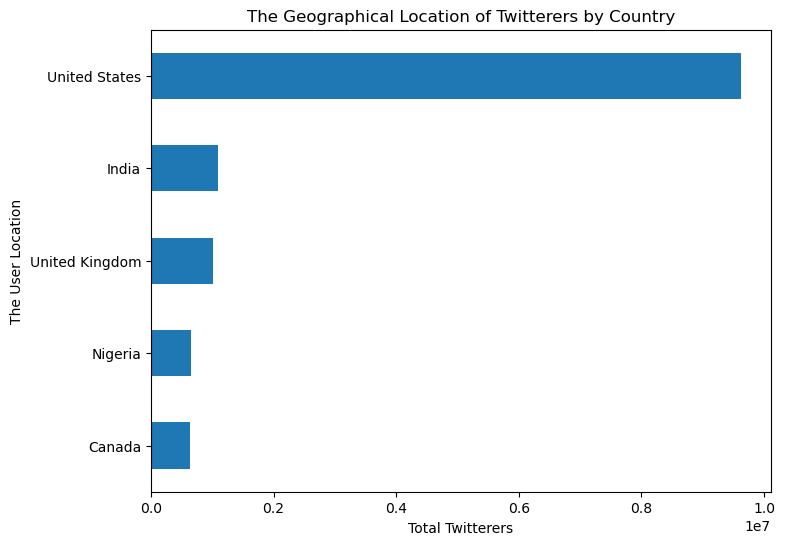

In [23]:
pd_sorted_location_df2_plot = pd_sorted_location_df2.plot(kind='barh',x='user_country', y='user_count', legend=None, title="The Geographical Location of Twitterers by Country", figsize=(8, 6))
pd_sorted_location_df2_plot.set_xlabel("Total Twitterers")
pd_sorted_location_df2_plot.set_ylabel("The User Location")

In [27]:
#pip install a-world-of-countries

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 4.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/usr/lib/spark/python/lib/py4j-0.10.9-src.zip/py4j/java_gateway.py", line 1207, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/spark/python/lib/py4j-0.10.9-src.zip/py4j/java_gateway.py", line 1033, in send_command
    response = connection.send_command(command)
  File "/usr/lib/spark/python/lib/py4j-0.10.9-src.zip/py4j/java_gateway.py", line 1211, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while receiving


In [24]:
import awoc
my_world = awoc.AWOC()

In [25]:
africa = my_world.get_countries_list_of('Africa')
africa = [x.lower() for x in africa]
africa1 = '|'.join([f'({c})' for c in africa])

europe1 = my_world.get_countries_list_of('Europe')
europe1 = [x.lower() for x in europe1]
europe3 = '|'.join([f'({c})' for c in europe1])

south_a = my_world.get_countries_list_of('South America')
south_a = [x.lower() for x in south_a]
south_a2 = '|'.join([f'({c})' for c in south_a])

north_a = my_world.get_countries_list_of('North America')
north_a = [x.lower() for x in north_a]
north_a2 = '|'.join([f'({c})' for c in north_a])

oceania = my_world.get_countries_list_of('Oceania')
oceania = [x.lower() for x in oceania]
oceania2 = '|'.join([f'({c})' for c in oceania])

asia = my_world.get_countries_list_of('Asia')
asia = [x.lower() for x in asia]
asia1 = '|'.join([f'({c})' for c in asia])

In [26]:
tweet_region = tweets_country.withColumn("user_region",
            when(lower(col("user_country")).rlike(africa1), "Africa")
           .when(lower(col("user_country")).rlike(europe3), "Europe")
           .when(lower(col("user_country")).rlike(south_a2), "South America")
           .when(lower(col("user_country")).rlike(north_a2), "North America")
           .when(lower(col("user_country")).rlike(oceania2), "Oceania")
           .when(lower(col("user_country")).rlike(asia1), "Asia")
           .otherwise(col("user_country")))

In [27]:
tweet_region.limit(10)

user_id,user_screen_name,user_location,user_category,tweet_text,tweet_created_at,year,month,day,hour,user_country,user_region
855619901716930560,Iviebihh,"downtown, atlanta",Someone Else,"The ""married by 2...",2022-08-02 13:50:41,2022,8,2,13,United States,North America
1132202998447378432,SA_Kolawole,nigeria,Someone Else,The University of...,2022-08-02 13:50:41,2022,8,2,13,Nigeria,Africa
986685574789713922,TravisBranham_,"lexington, ky",Social Media Infl...,"Kwame 'KJ' Evans,...",2022-08-02 13:50:42,2022,8,2,13,United States,North America
1351845066592169986,YAMII_SAMAA,"lagos, nigeria",Someone Else,WTF is a 25 year ...,2022-08-02 13:50:43,2022,8,2,13,Nigeria,Africa
87832393,NJASL,"trenton, new jersey",University,@CHHCS @RobinCoga...,2022-08-02 13:50:43,2022,8,2,13,United States,North America
857582923247222784,MahutsRue,zimbabwe,Someone Else,Universities also...,2022-08-02 13:50:45,2022,8,2,13,zimbabwe,Africa
1173774376723996672,toniesposito3,"staten island, ny",Someone Else,I only need $204 ...,2022-08-02 13:50:47,2022,8,2,13,United States,North America
1547955713242124292,SuMin99_,españa,Someone Else,Where are those k...,2022-08-02 13:50:49,2022,8,2,13,españa,españa
716440796,TheFundBalt,baltimore city,University,City Schools is s...,2022-08-02 13:50:50,2022,8,2,13,United States,North America
434526754,KiingPrince757,va beach,Someone Else,I wanna run throu...,2022-08-02 13:50:50,2022,8,2,13,United States,North America


In [28]:
continent = ['Africa','Europe','South America','North America','Oceania','Asia']
continent2 = '|'.join([f'({c})' for c in continent])

In [29]:
pd_location_df3 = tweet_region.groupBy('user_region').agg(count('user_id').alias('user_count'))\
.orderBy('user_count',ascending=False)\
.filter(tweet_region['user_region'].rlike(continent2)).toPandas()

In [30]:
pd_location_df3.head(10)

,user_region,user_count
0,North America,10356527
1,Asia,1690232
2,Europe,1380771
3,Africa,1372837
4,Oceania,137252
5,South America,84329


In [31]:
pd_location_df3 = pd_location_df3.iloc[::-1]

Text(0, 0.5, 'The User Region')

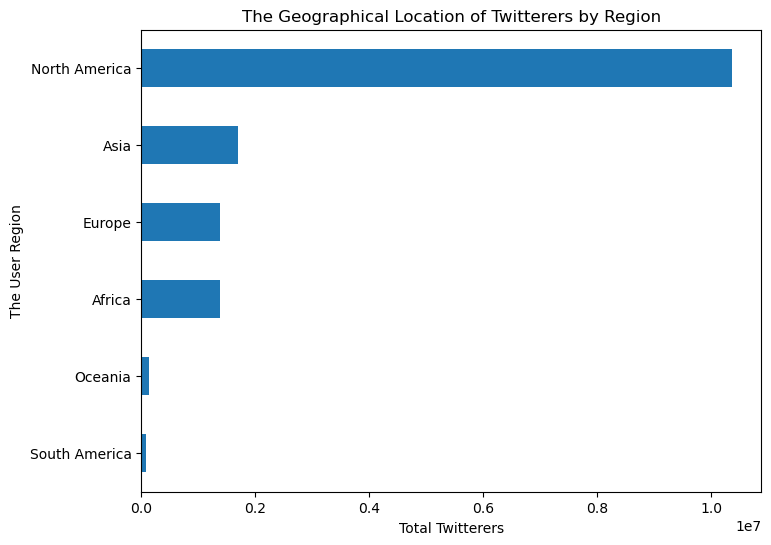

In [32]:
pd_location_df3_plot = pd_location_df3.plot(kind='barh',x='user_region', y='user_count', legend=None, title="The Geographical Location of Twitterers by Region", figsize=(8, 6))
pd_location_df3_plot.set_xlabel("Total Twitterers")
pd_location_df3_plot.set_ylabel("The User Region")

## Question 4b: Do you see any relationship between the emergence of new issues in education and progression and locations of these Twitterers?

Based on my research on the emergence of new issues in education, I will be analyzing these two topics: **Student Loan Forgiveness" and Teacher's Salaries**

In [33]:
from pyspark.ml.feature import RegexTokenizer

unwanted_expression = RegexTokenizer(inputCol="tweet_text", outputCol="words", pattern="\\W")

lower_case = udf(lambda x: x.lower())

tweet_region = tweet_region.withColumn("tweet_text", lower(regexp_replace("tweet_text", "[\$#,&%\".]", "")))
tweet_region = unwanted_expression.transform(tweet_region)
tweet_region = tweet_region.withColumn("tweet_text", concat_ws(" ", "words"))
tweet_region = tweet_region.drop("words")

In [34]:
#key words for the topics
SLF_key = ['student loan', 'debt relief', 'loan forgiveness', 'loan payoff', 'student loan debt',
          'public service loan forgiveness']

TS_key = ['teacher pay raise', 'teacher salary reform', 'teacher pay', 'teacher compensation',
         'salary increase for teachers', 'fair teacher wages', 'educator salaries', 'teacher salary negotiations']

In [35]:
SLF_pattern = "|".join(SLF_key)
TS_pattern = "|".join(TS_key)

In [36]:
tweet_region2 = tweet_region.withColumn("emergent_issue",
            when(lower(col("tweet_text")).rlike(SLF_pattern), "Student Loan")
           .when(lower(col("tweet_text")).rlike(TS_pattern), "Teacher Salaries")
           .otherwise("None"))

### Student loan forgiveness per country

In [37]:
#filter for student loan
std_loan = tweet_region2.filter(tweet_region2.emergent_issue == 'Student Loan')
std_loan.count()

117065

In [39]:
std_loan.limit(5)

user_id,user_screen_name,user_location,user_category,tweet_text,tweet_created_at,year,month,day,hour,user_country,user_region,emergent_issue
29137381,laran3313,consciousness,News Outlet,something i ve be...,2022-08-31 01:12:51,2022,8,31,1,consciousness,consciousness,Student Loan
578625464,centralgirl2010,"kansas, usa",Someone Else,bipartisan s2598 ...,2022-08-31 01:13:27,2022,8,31,1,United States,North America,Student Loan
3433409499,MoneyVisCoach,"chicago,il",Someone Else,the federal stude...,2022-08-31 01:14:18,2022,8,31,1,United States,North America,Student Loan
16713534,angelsscream,"chicago, il",Someone Else,something i ve be...,2022-08-31 01:14:31,2022,8,31,1,United States,North America,Student Loan
50056568,cubsncards,st. simons island...,Someone Else,why do i a colleg...,2022-08-31 01:15:33,2022,8,31,1,United States,North America,Student Loan


In [40]:
location_df4 = std_loan.groupBy("user_country").agg({"emergent_issue": "count"}).withColumnRenamed("count(emergent_issue)", "issue_count")

In [41]:
#sort the data in descending order
sorted_location_df4 = location_df4.sort(col("issue_count").desc())

In [42]:
pd_sorted_location_df4 = sorted_location_df4.limit(4).toPandas()
pd_sorted_location_df4.head(4)

,user_country,issue_count
0,United States,80691
1,Canada,2673
2,United Kingdom,2219
3,Nigeria,1073


In [43]:
pd_sorted_location_df4 = pd_sorted_location_df4.iloc[::-1]

Text(0, 0.5, 'The User Region')

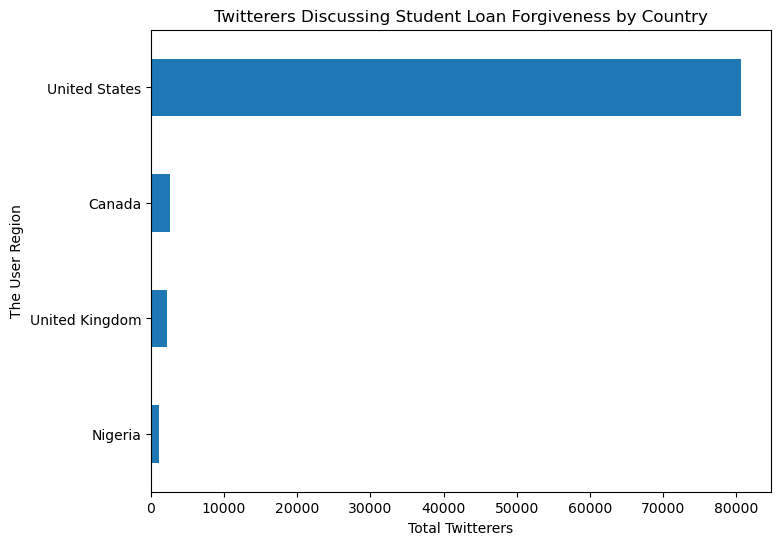

In [44]:
sorted_location_df4_plot = pd_sorted_location_df4.plot(kind='barh',x='user_country', y='issue_count', legend=None, title="Twitterers Discussing Student Loan Forgiveness by Country", figsize=(8, 6))
sorted_location_df4_plot.grid(False)
sorted_location_df4_plot.set_xlabel("Total Twitterers")
sorted_location_df4_plot.set_ylabel("The User Region")

### Check the timeline of the tweets for students loan forgiveness

In [45]:
#use the "createOrReplaceTempView" to store my dataframe in order to run SparkSQL statements against the data
std_loan.createOrReplaceTempView("std_loan_data")

In [46]:
tweets_timeline2 = spark.sql(\
                              "SELECT year, month, day, count(*) AS total_tweets\
                              FROM std_loan_data\
                              GROUP BY year, month, day\
                              ORDER BY month")

In [ ]:
pd_tweets_timeline2 = tweets_timeline2.limit(1_000).toPandas()
pd_tweets_timeline2.head(5)

,year,month,day,total_tweets
0,2023,1,25,54
1,2023,1,17,82
2,2023,1,26,65
3,2023,1,2,33
4,2023,1,4,66


In [49]:
pd_tweets_timeline2["year"].unique()

array([2023, 2022], dtype=int32)

In [50]:
#Filtering to get the monthly and daily tweet in 2022
pd_tweets_timeline_2_22 = pd_tweets_timeline2[pd_tweets_timeline2['year'] == 2022]
pd_tweets_timeline_2_22.head(5)

,year,month,day,total_tweets
39,2022,4,29,5623
40,2022,4,6,376
41,2022,4,17,107
42,2022,4,19,139
43,2022,4,15,114


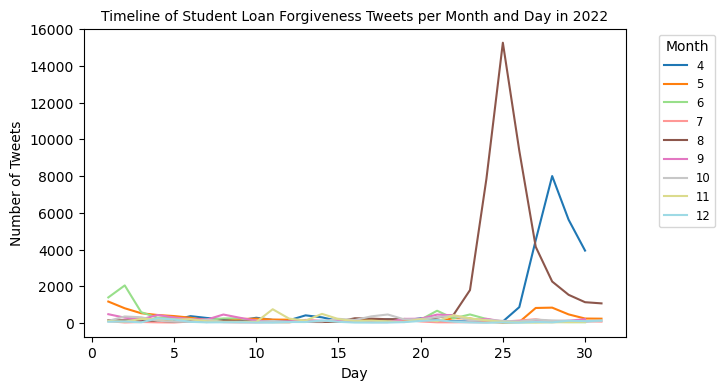

In [52]:
# Plot the timeline of tweets per month and day
cmap = plt.cm.tab20

fig, ax = plt.subplots(figsize=(7, 4))
pd_tweets_timeline_2_22.pivot(index='day', columns='month', values='total_tweets').plot(ax=ax, cmap=cmap)
plt.xlabel('Day')
plt.ylabel('Number of Tweets')
plt.title('Timeline of Student Loan Forgiveness Tweets per Month and Day in 2022', fontsize=10)
legend = plt.legend(title="Month", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.show()

In [53]:
#Filtering to get the monthly and daily tweet in 2023
pd_tweets_timeline_23 = pd_tweets_timeline2[pd_tweets_timeline2['year'] == 2023]
pd_tweets_timeline_23.head(5)

,year,month,day,total_tweets
0,2023,1,25,54
1,2023,1,17,82
2,2023,1,26,65
3,2023,1,2,33
4,2023,1,4,66


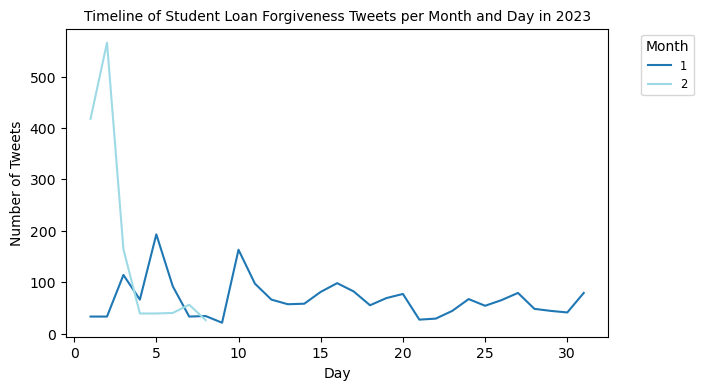

In [54]:
# Plot the timeline of tweets per month and day
cmap = plt.cm.tab20

fig, ax = plt.subplots(figsize=(7, 4))
pd_tweets_timeline_23.pivot(index='day', columns='month', values='total_tweets').plot(ax=ax, cmap=cmap)
plt.xlabel('Day')
plt.ylabel('Number of Tweets')
plt.title('Timeline of Student Loan Forgiveness Tweets per Month and Day in 2023', fontsize=10)
legend = plt.legend(title="Month", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.show()

### Student loan forgiveness per region

In [55]:
pd_location_df5 = std_loan.groupBy('user_region').agg(count('emergent_issue').alias('issue_count'))\
.orderBy('issue_count',ascending=False)\
.filter(std_loan['user_region'].rlike(continent2)).toPandas()

In [56]:
pd_location_df5.head(10)

,user_region,issue_count
0,North America,83705
1,Europe,3183
2,Africa,1724
3,Asia,1036
4,Oceania,368
5,South America,149


In [57]:
pd_location_df5 = pd_location_df5.iloc[::-1]

Text(0, 0.5, 'The User Region')

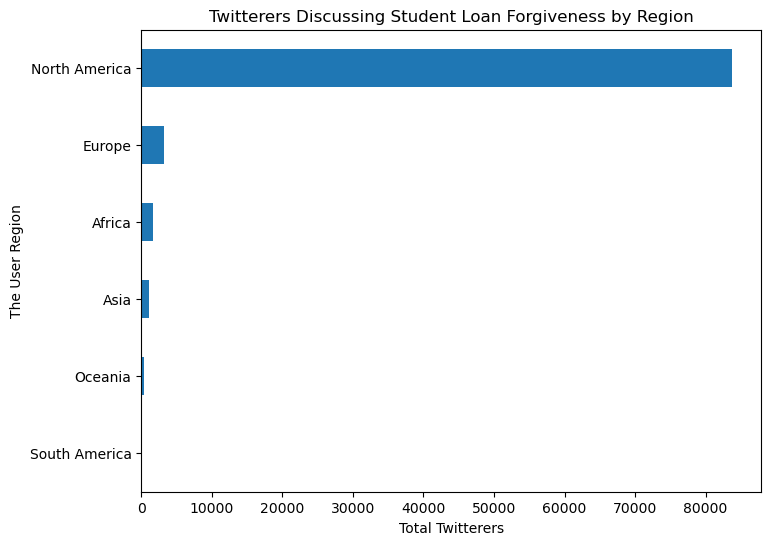

In [58]:
pd_location_df5_plot = pd_location_df5.plot(kind='barh',x='user_region', y='issue_count', legend=None, title="Twitterers Discussing Student Loan Forgiveness by Region", figsize=(8, 6))
pd_location_df5_plot.grid(False)
pd_location_df5_plot.set_xlabel("Total Twitterers")
pd_location_df5_plot.set_ylabel("The User Region")

### Student loan forgiveness by organization

In [59]:
location_df2a = std_loan.groupBy("user_category").agg({"emergent_issue": "count"}).withColumnRenamed("count(emergent_issue)", "issue_count")

In [60]:
#sort the data in descending order
sorted_location_df2a = location_df2a.sort(col("issue_count").desc())
sorted_location_df2a.limit(10)

user_category,issue_count
Someone Else,95700
News Outlet,6015
Government Entity,5354
Social Media Infl...,5089
University,4091
Nonprofit Organiz...,659
School,157


### Teacher's salaries per country

In [61]:
#filter for teacher's salaries
ts_df = tweet_region2.filter(tweet_region2.emergent_issue == 'Teacher Salaries')
ts_df.count()

9174

In [62]:
ts_df.limit(5)

user_id,user_screen_name,user_location,user_category,tweet_text,tweet_created_at,year,month,day,hour,user_country,user_region,emergent_issue
2491487924,SchoolsWeek,"greenwich, london",University,union demands to ...,2023-02-01 17:34:00,2023,2,1,17,United Kingdom,Europe,Teacher Salaries
1109894199032328192,pwb85742,"tucson, az",Someone Else,greg abbott is ly...,2022-10-01 04:48:30,2022,10,1,4,United States,North America,Teacher Salaries
114886324,rockilu,"austin, tx",Someone Else,after abbott says...,2022-10-01 04:48:53,2022,10,1,4,United States,North America,Teacher Salaries
813572101550604288,Thoreaus_Horse,united states,Someone Else,79 of florida s k...,2022-09-26 13:42:06,2022,9,26,13,United States,North America,Teacher Salaries
547245452,MaryPapazian,california,University,importance of int...,2022-10-24 16:44:34,2022,10,24,16,United States,North America,Teacher Salaries


In [63]:
location_df6 = ts_df.groupBy("user_country").agg({"emergent_issue": "count"}).withColumnRenamed("count(emergent_issue)", "issue_count")

In [64]:
#sort the data in descending order
sorted_location_df6 = location_df6.sort(col("issue_count").desc())

In [ ]:
pd_sorted_location_df6 = sorted_location_df6.limit(4).toPandas()
pd_sorted_location_df6.head(4)

,user_country,issue_count
0,United States,6544
1,United Kingdom,710
2,"marsala, sicily",135
3,Canada,133


In [66]:
pd_sorted_location_df6['user_country'] = pd_sorted_location_df6['user_country'].replace('marsala, sicily', 'Italy')

In [67]:
pd_sorted_location_df6 = pd_sorted_location_df6.iloc[::-1]

Text(0, 0.5, 'The User Country')

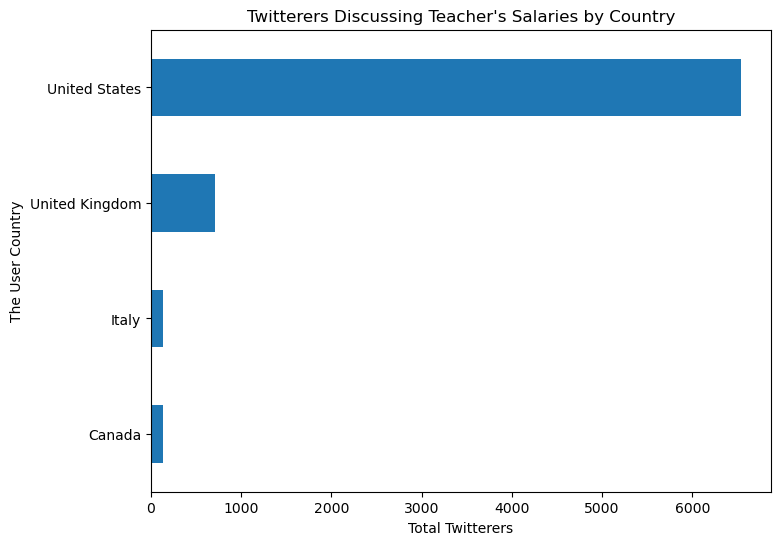

In [68]:
sorted_location_df6_plot = pd_sorted_location_df6.plot(kind='barh',x='user_country', y='issue_count', legend=None, title="Twitterers Discussing Teacher's Salaries by Country", figsize=(8, 6))
sorted_location_df6_plot.grid(False)
sorted_location_df6_plot.set_xlabel("Total Twitterers")
sorted_location_df6_plot.set_ylabel("The User Country")

### Check the timeline of the tweets for teacher's salaries

In [69]:
#use the "createOrReplaceTempView" to store my dataframe in order to run SparkSQL statements against the data
ts_df.createOrReplaceTempView("ts_df_data")

In [72]:
tweets_timeline2 = spark.sql(\
                              "SELECT year, month, day, count(*) AS total_tweets\
                              FROM ts_df_data\
                              GROUP BY year, month, day\
                              ORDER BY month")

In [73]:
pd_tweets_timeline2 = tweets_timeline2.limit(1_000).toPandas()
pd_tweets_timeline2.head(5)

,year,month,day,total_tweets
0,2023,1,10,15
1,2023,1,30,46
2,2023,1,22,9
3,2023,1,23,256
4,2023,1,6,5


In [74]:
pd_tweets_timeline2["year"].unique()

array([2023, 2022], dtype=int32)

In [75]:
#Filtering to get the monthly and daily tweet in 2022
pd_tweets_timeline_2_22 = pd_tweets_timeline2[pd_tweets_timeline2['year'] == 2022]
pd_tweets_timeline_2_22.head(5)

,year,month,day,total_tweets
39,2022,4,19,13
40,2022,4,26,17
41,2022,4,25,14
42,2022,4,23,29
43,2022,4,28,52


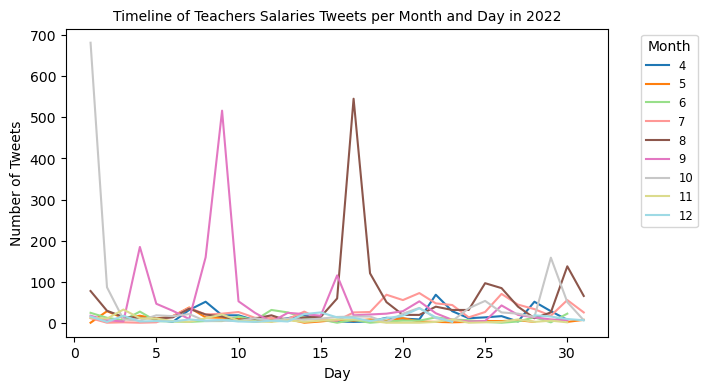

In [76]:
# Plot the timeline of tweets per month and day
cmap = plt.cm.tab20

fig, ax = plt.subplots(figsize=(7, 4))
pd_tweets_timeline_2_22.pivot(index='day', columns='month', values='total_tweets').plot(ax=ax, cmap=cmap)
plt.xlabel('Day')
plt.ylabel('Number of Tweets')
plt.title('Timeline of Teachers Salaries Tweets per Month and Day in 2022', fontsize=10)
legend = plt.legend(title="Month", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.show()

In [77]:
#Filtering to get the monthly and daily tweet in 2023
pd_tweets_timeline_23 = pd_tweets_timeline2[pd_tweets_timeline2['year'] == 2023]
pd_tweets_timeline_23.head(5)

,year,month,day,total_tweets
0,2023,1,10,15
1,2023,1,30,46
2,2023,1,22,9
3,2023,1,23,256
4,2023,1,6,5


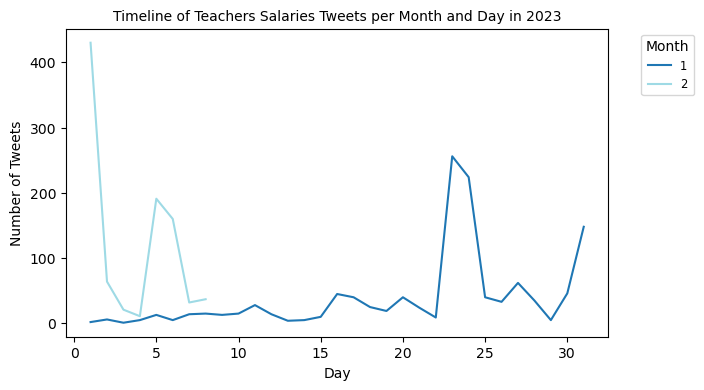

In [78]:
# Plot the timeline of tweets per month and day
cmap = plt.cm.tab20

fig, ax = plt.subplots(figsize=(7, 4))
pd_tweets_timeline_23.pivot(index='day', columns='month', values='total_tweets').plot(ax=ax, cmap=cmap)
plt.xlabel('Day')
plt.ylabel('Number of Tweets')
plt.title('Timeline of Teachers Salaries Tweets per Month and Day in 2023', fontsize=10)
legend = plt.legend(title="Month", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.show()

### Teacher's salaries per region

In [79]:
pd_location_df7 = ts_df.groupBy('user_region').agg(count('emergent_issue').alias('issue_count'))\
.orderBy('issue_count',ascending=False)\
.filter(ts_df['user_region'].rlike(continent2)).toPandas()

In [80]:
pd_location_df7.head(10)

,user_region,issue_count
0,North America,6686
1,Europe,754
2,Asia,53
3,Africa,32
4,Oceania,32
5,South America,6


In [81]:
pd_location_df7 = pd_location_df7.iloc[::-1]

Text(0, 0.5, 'The User Region')

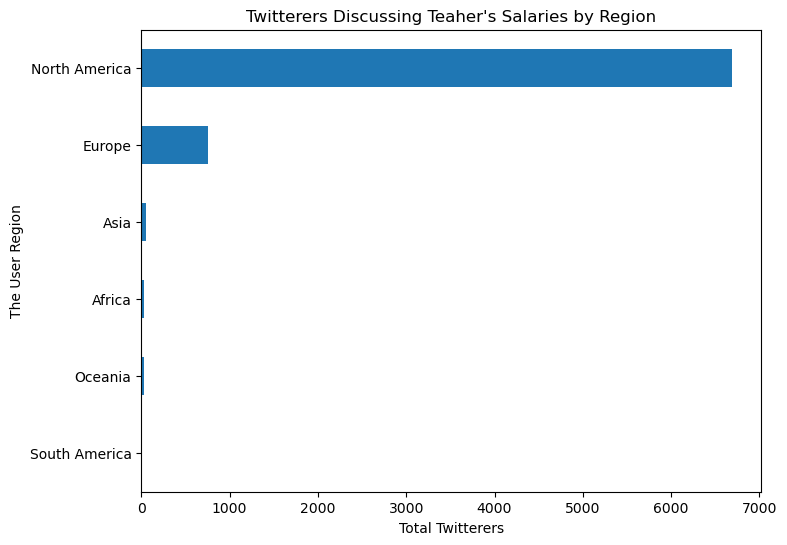

In [82]:
pd_location_df7_plot = pd_location_df7.plot(kind='barh',x='user_region', y='issue_count', legend=None, title="Twitterers Discussing Teaher's Salaries by Region", figsize=(8, 6))
pd_location_df7_plot.grid(False)
pd_location_df7_plot.set_xlabel("Total Twitterers")
pd_location_df7_plot.set_ylabel("The User Region")

### Teacher's salaries by organization

In [83]:
location_df2b = ts_df.groupBy("user_category").agg({"emergent_issue": "count"}).withColumnRenamed("count(emergent_issue)", "issue_count")

In [85]:
#sort the data in descending order
sorted_location_df2b = location_df2b.sort(col("issue_count").desc())
sorted_location_df2b.limit(10)

user_category,issue_count
Someone Else,6916
Government Entity,648
University,587
News Outlet,508
Social Media Infl...,421
Nonprofit Organiz...,60
School,34


### Teacher's salaries by twitterers

In [86]:
location_df2c = ts_df.groupBy("user_screen_name").agg({"emergent_issue": "count"}).withColumnRenamed("count(emergent_issue)", "issue_count")

In [87]:
#sort the data in descending order
sorted_location_df2c = location_df2c.sort(col("issue_count").desc())
sorted_location_df2c.limit(10)

user_screen_name,issue_count
MrMilitantRBKA,135
RebekahDennis29,14
jwatsondp,12
ocsurf74,10
tes,9
NCTQ,7
NShrubs,7
paulperez1949,7
schoolsontap,7
RandyAlberhasky,6


### Student loan forgiveness by twitterers

In [88]:
location_df2d = std_loan.groupBy("user_screen_name").agg({"emergent_issue": "count"}).withColumnRenamed("count(emergent_issue)", "issue_count")

In [ ]:
#sort the data in descending order
sorted_location_df2d = location_df2d.sort(col("issue_count").desc())
sorted_location_df2d.limit(10)

user_screen_name,issue_count
dorislindaB,192
MoneyVisCoach,113
Presproverbs,105
4slj_,103
INvestEdIndiana,69
Emmaheather053,51
sugar_mommakell,45
FlagstaffJon,42
dwright100,39
chilberg11,36
